Da fare:
1. m_in vs m_out ad alpha' fissato (P=90/500/N*d/32) per N=250,500,1000
2. La rappresentazione degli autovettori è quella giusta?

Fatto:
1. Studio in N a d fisso (fatto)
2. Studio in d, a P fissato con alpha1 (fatto)

# Libraries and functions

## libraries

In [14]:
## Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize, BoundaryNorm
plt.rcParams.update({'font.size': 14})
import random
import math
from tqdm import tqdm
import time

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import gc


from google.colab import drive
drive.mount('/content/gdrive')
data_PATH = "gdrive/MyDrive/Associative_memory/vectorial_hopfield/notebooks_first_step/graphs_savings/"

DATASET_PATH = "../data"

CHECKPOINT_PATH = "../saved_models"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cos = nn.CosineSimilarity(dim=-1)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Device: cuda:0


## Functions

In [2]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, name, print=True, best_valid_loss=-float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.print = print
        self.name = name

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, time
    ):
        if current_valid_loss > self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            if self.print==True:
                print("Saving best model for epoch: %d, current val loss: %.4e, t: %.1f\n" % (epoch+1, current_valid_loss, time))
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                "time": time,
                }, self.name)

def loss_single_i(output):                        #out.shape = [B]
    g_i_b = output
    loss = g_i_b.mean()
    return loss

In [3]:
from math import ceil

def plot_eigenvalues_subplots(eigs_arr, n, magn, title, d_arr = None, alpha_1=0, mode=0):
    # 3 subplots per row
    rows = ceil(n / 3)
    cols = 3 if n >= 3 else n  # maximum 3 columns

    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()

    for i in range(n):
        if mode != 2:
            eigenvalues = eigs_arr[:, i]
        else:
            eigenvalues = eigs_arr[i]

        # Separate positive and negative values
        positive_values = eigenvalues[eigenvalues > 0]
        negative_values = eigenvalues[eigenvalues <= 0]

        # histogram for positive values
        axs[i].hist(positive_values, bins=50, alpha=0.7, label='Positive Values')

        # individual points for negative values
        axs[i].scatter(negative_values, [0] * len(negative_values), color='red', label='Negative Values')

        axs[i].set_xlabel('Eigenvalues')
        axs[i].set_ylabel('Frequency')
        if mode==0:
            axs[i].set_title(f'm={magn[i]:.3f}, n={i+1}, Negative = {len(negative_values)}/{len(negative_values) + len(positive_values)}')
        elif mode==1:
            axs[i].set_title(f'alpha1={alpha1_arr[i]*N*d:.3f}, Negative = {len(negative_values)}/{len(negative_values) + len(positive_values)}')
        elif mode==2:
            axs[i].set_title(f'd:{d_arr[i]}, P:{int(alpha1*N*d_arr[i])}, Neg:{len(negative_values)}/{len(negative_values) + len(positive_values)}, m:{magn[i]:.3f}')
        axs[i].legend()
        axs[i].set_xlim(-0.15,1.25)

    # turn off any unused subplots
    for j in range(i+1, rows * cols):
        axs[j].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [4]:
def converge_input_vector_compute_overlap(input_data, model, init_overlap, n):
    input_vectors = gen_rotated_conf(input_data, init_overlap)             ########### FUNCTION INIT OVERLAP

    input_vectors = model.normalize_x(input_vectors)
    input_vectors = input_vectors.to(device)
    x_new = input_vectors.clone()
    for i_n in range(n):
        x_new = model.dyn_step(x_new)  #[B, n, N,i]
    overlap = torch.einsum('bid,bid->b', x_new, input_data)  #[b,n]
    return overlap

def basins_of_attraction_inp_vectors(input_data, init_overlaps_array, model, n):
    max_overlap_inp_vectors_list = []

    # Loop over each init_overlap value
    for init_overlap in init_overlaps_array:
        # Generate input_vectors based on the init_overlap
        overlaps = converge_input_vector_compute_overlap(input_data, model, init_overlap, n)
        max_overlap_inp_vectors_list.append(overlaps.detach().cpu())

    # Convert the list to a NumPy array
    max_overlap_inp_vectors_array = np.array(max_overlap_inp_vectors_list)
    return max_overlap_inp_vectors_array

def gen_rotated_conf(S,q):
    B,N,d = S.shape

    if d>1:
        rand_orth_conf = gen_rand_orth_conf(S)
        noisy_S = np.sqrt(1-q*q) * rand_orth_conf + q * S
    else:
        flip_prob = (1-q)/2  # Fraction of spins to flip
        mask = torch.bernoulli(torch.full(S.shape, flip_prob, device=S.device))  # Generate flip mask
        noisy_S = S.clone()  # Make a copy of S
        noisy_S[mask.bool()] = 1 - noisy_S[mask.bool()]  # Flip spins (0 -> 1, 1 -> 0)



    return noisy_S

In [5]:
def gen_rand_orth_conf(S):
    B,N,d = S.shape

    rand_conf = torch.randn(B,N,d).to(device)
    rand_conf /= torch.linalg.norm(rand_conf,dim=-1,keepdims=True)

    rand_orth_conf = torch.zeros((B,N,d)).to(device)

    ## TODO this for loop might be inefficient
    ## maybe use something like
    ## projector = np.tensordot(np.transpose(rand_conf),rand_conf,axes=0)
    for i in range(N):
        x = S[:, i, :].clone()  # Shape: [B, d]
        r = rand_conf[:, i, :].clone()  # Shape: [B, d]

        # Compute the parallel projector
        parall_projector = torch.einsum('bi,bj->bij', x, x)  # Shape: [B, d, d]

        # Compute the orthogonalizer
        orthogonalizer = torch.eye(d, device=S.device).unsqueeze(0) - parall_projector  # Shape: [B, d, d]

        # Orthogonalize r
        orth_r = torch.einsum('bij,bj->bi', orthogonalizer, r)  # Shape: [B, d]
        rand_orth_conf[:, i, :] = orth_r.clone()

    # Normalize along the d-dimension
    rand_orth_conf /= torch.norm(rand_orth_conf, dim=2, keepdim=True)

    return rand_orth_conf

In [6]:
def create_xi_list(xi, num_of_run, mix_order, seed=42):

    torch.manual_seed(seed)
    P, N, d = xi.shape
    xi_list = torch.zeros(num_of_run, mix_order, N, d, device=xi.device)

    for i_run in range(num_of_run):
        idx = torch.randperm(P)[:mix_order]
        xi_list[i_run] = xi[idx]

    return xi_list


## Dynamics analisys functions

In [7]:
import torch

def max_overlap(x_new, vectors):
    """
    Computes the maximum overlap and corresponding indices between x_new and vectors.

    Args:
    - x_new: Tensor of shape [batch_size, n, N, d].
    - vectors: Tensor of shape [X, N, d].

    Returns:
    - overlap_max: Tensor of maximum overlap values of shape [batch_size].
    - max_values: Tensor of corresponding max values of shape [batch_size].
    """
    batch_size, n, N, d = x_new.shape
    X = vectors.shape[0]

    dot_products = torch.einsum('bnid,xid->bnxi', x_new, vectors)

    dot_products_mean = dot_products.mean(dim=3)    #[b,n,x]

    overlap_max_n, overlap_argmax_n = torch.max(dot_products_mean, dim=-1)

    overlap_max, overlap_argmax = torch.max(overlap_max_n, dim=1)
    max_values = overlap_max_n.gather(1, overlap_argmax.unsqueeze(-1)).squeeze()

    return overlap_max_n.cpu().numpy(), overlap_max.cpu().numpy(), max_values.cpu().numpy(), overlap_argmax.cpu().numpy()


In [8]:
def converge(input_vectors, model, dataset, n, features=False):
    """
    Function to perform dynamics and compute overlaps.

    Args:
    - input_vectors: Tensor of shape [batch_size, N, d].
    - model: The model instance with a dyn_n_step method.
    - dataset: The dataset instance containing xi and f.
    - n: The number of steps to simulate.

    Returns:
    - max_overlap_xi: Tensor of max overlap values with xi.
    - max_overlap_f: Tensor of max overlap values with f.
    - final_overlap: Tensor of final overlap values with input_vectors.
    """

    input_vectors = input_vectors.to(device)
    x_new = model.dyn_n_step(input_vectors, n)  #[B,n,N,d]

    overlap_max_n_xi, max_overlap_xi, _,overlap_argmax = max_overlap(x_new, dataset.xi.to(device))
    if features == True:
        overlap_max_n_f, max_overlap_f, _ = max_overlap(x_new, dataset.f.to(device))
    else:
        overlap_max_n_f = np.zeros_like(overlap_max_n_xi)
        max_overlap_f = np.zeros_like(max_overlap_xi)

    input_overlap_n = torch.einsum('bnid,bid->bni', x_new, input_vectors).mean(dim=-1)  #[b,n]
    max_input_overlap = torch.max(input_overlap_n, dim=1)[0].cpu().numpy()

    return overlap_max_n_xi, overlap_max_n_f, max_overlap_xi, max_overlap_f, input_overlap_n, max_input_overlap, overlap_argmax

In [9]:
def overlap_matrix(eighs_arr, eigenvectors_arr, xi):
    # Step 1: Select eigenvalues <= 0
    negative_eigen_mask = eighs_arr <= 0

    # Step 2: Select and sort eigenvalues and eigenvectors based on this condition
    negative_eighs = eighs_arr[negative_eigen_mask]
    negative_eigenvectors = eigenvectors_arr[negative_eigen_mask]

    # Step 3: Sort eigenvalues and corresponding eigenvectors by most negative eigenvalues first
    sorted_indices = np.argsort(negative_eighs)  # Sort in ascending order
    sorted_eighs = negative_eighs[sorted_indices]
    sorted_eigenvectors = negative_eigenvectors[sorted_indices]

    # Step 4: Compute the overlap matrix
    num_negative_eigenvalues = len(sorted_eighs)
    P, N, d = xi.shape

    xi_gpu = torch.from_numpy(xi).type(torch.float64).to(device)
    sorted_eigenvectors_gpu = torch.from_numpy(sorted_eigenvectors).to(device)
    overlap_matrix = torch.einsum("pnd,bnd->bp", xi_gpu, sorted_eigenvectors_gpu).cpu().numpy()/N

    # Iterate over the sorted eigenvectors
    #for i in range(num_negative_eigenvalues):
    #    for mu in range(len(xi)):
        # Compute the dot product between the i-th eigenvector and xi over the last axis (axis 2)
        # Then, take the mean over axis 1 (N dimension in eigenvectors and xi)
            #print(np.mean(np.dot(xi[mu], sorted_eigenvectors[i].T), axis=1).shape)
            #overlap_matrix[i,mu] = np.mean(np.dot(xi[mu], sorted_eigenvectors[i].T))

    return overlap_matrix


# Models

In [10]:
import torch
import torch.nn as nn

class TwoBodiesModel(nn.Module):
    def __init__(self, N, d, on_sphere):
        super(TwoBodiesModel, self).__init__()
        self.N = N
        self.d = d
        self.on_sphere = on_sphere

        self.J = nn.Parameter(torch.randn(N, N, d, d))
        self.normalize_J(self.J)

    def normalize_J(self, J):
        with torch.no_grad():
            J = J/self.N

    def normalize_x(self, x):
        """
        Normalize each d-dimensional vector in x on the sphere if self.on_sphere is True.
        """
        if self.on_sphere:
            with torch.no_grad():
                norms = x.norm(dim=-1, keepdim=True)+1e-9
                x = x / norms
        return x

    def compute_local_fields(self, state_gpu):
        return torch.einsum("ijab,jb->ia",self.J, state_gpu)

    def Hebb(self, xi, form, verbose=False):
        """
        Calculates J based on the Hebb rule.
        xi -- input tensor of shape [P, N, d]
        form -- a string, either "Isotropic" or "Tensorial"
        """
        P = xi.shape[0]  # Number of patterns
        N = self.N
        d = self.d

        if form not in ["Isotropic", "Tensorial"]:
            raise ValueError("Form must be either 'Isotropic' or 'Tensorial'")

        # Zero out self.J to calculate the new values based on xi
        with torch.no_grad():
            self.J.zero_()

            # Hebbian rule for Isotropic or Tensorial form
            if form == "Isotropic":
                for mu in range(P):
                    # For Isotropic form: J_ij = (1/N) * sum(xi_i^mu * xi_j^mu)
                    for i in range(N):
                        for j in range(N):
                            if i != j:
                                self.J[i, j, :, :] += torch.sum(xi[mu, i, :] * xi[mu, j, :]) / N
            elif form == "Tensorial":
                if verbose == True:
                    for mu in tqdm(range(P)):
                        xi_mu = xi[mu].to(device)  # Shape: (N, D)
                        outer_products = torch.einsum('ia,jb->ijab', xi_mu, xi_mu) / N  # Shape: (N, N, D)

                        # Zero out diagonal elements
                        indices = torch.arange(N)
                        outer_products[indices, indices] = 0

                        # Update self.J
                        self.J += outer_products
                else:
                    for mu in range(P):
                        xi_mu = xi[mu].to(device)  # Shape: (N, D)
                        outer_products = torch.einsum('ia,jb->ijab', xi_mu, xi_mu) / N  # Shape: (N, N, D)

                        # Zero out diagonal elements
                        indices = torch.arange(N)
                        outer_products[indices, indices] = 0

                        # Update self.J
                        self.J += outer_products

    def dyn_step(self, x, a=None):
        """
        Computes x_{t+1} = sum_j J_ij * x_j and then normalizes it.
        x -- input tensor of shape [N, d]
        """
        B, N, d = x.shape
        with torch.no_grad():
            if a is None:
                x_new = torch.einsum('ijab,Bjb->Bia', self.J, x)
            else:
                x_new = x + a*torch.einsum('ijab,Bjb->Bia', self.J, x)
            x_new = self.normalize_x(x_new)
        return x_new

    def dyn_n_step(self, x, n, a=None, verbose=False):
        """
        Computes the dynamics for n steps.
        Args:
        x -- input tensor of shape [B, N, d]
        n -- number of steps
        Returns:
        Tensor of shape [B, n, N, d] containing the dynamics over n steps
        """
        B, N, d = x.shape
        # Initialize the tensor to store the states over n steps
        x_new = torch.zeros((n, B, N, d), device=x.device)
        x_new_temp = x.clone()

        # Iterate and evolve the system for n steps
        if verbose==True:
            for t in tqdm(range(n)):
                x_new_temp = self.dyn_step(x_new_temp, a)
                x_new[t] = x_new_temp
        else:
            for t in range(n):
                x_new_temp = self.dyn_step(x_new_temp, a)
                x_new[t] = x_new_temp

        return x_new.permute(1, 0, 2, 3)

    def run_dynamics_mixture(self, xi_list, q0, n, coeff_list=None):

        mix_order = len(xi_list[0,:,0,0])
        B = len(xi_list[:,0,0,0])

        if coeff_list is None:
            coeff_list = torch.ones(mix_order)

        mix = torch.einsum("l,blid->bid", coeff_list, xi_list)
        mix = mix.to(device)

        mix = self.normalize_x(mix)

        ## add noise
        noisy_mix = gen_rotated_conf(mix,q0)

        overlap_single = torch.zeros((B,n+1,mix_order+1))

        overlap_single[:,0,:-1] = torch.einsum('blid,bid->bl', xi_list, noisy_mix)/N
        overlap_single[:,0,-1] = torch.einsum('bid,bid->b', noisy_mix, mix)/N

        for iter in range(1,n+1):
            noisy_mix = self.dyn_step(noisy_mix)
            overlap_single[:,iter,:-1] = torch.einsum('blid,bid->bl', xi_list, noisy_mix)/N
            overlap_single[:,iter,-1] = torch.einsum('bid,bid->b', noisy_mix, mix)/N

        return overlap_single

    def forward(self, xi):
        """

        """
        return self.J


# Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, P, N, D, d, sigma, seed=None, on_sphere=True, coefficients="binary"):
        """
        P: Number of patterns
        N: Number of sites
        D: Number of features in the random features (not implemented)
        d: Dimensionality of each site
        sigma: Standard deviation of the Gaussian noise
        on_sphere: If True, normalize data to lie on a sphere
        coefficients: Type of coefficients ('binary' or 'gaussian')
        """
        self.P = P
        self.N = N
        self.D = D
        self.d = d
        self.sigma = sigma
        self.on_sphere = on_sphere
        self.coefficients = coefficients

        if seed is not None:
            torch.manual_seed(seed)

        # xi of shape [P, N, d]
        self.xi = torch.randn(P, N, d) * sigma

        # Normalize xi along last dimension if on_sphere is True
        if self.on_sphere:
            self.xi = self.normalize(self.xi)


    def normalize(self, x):
        # Normalize each d-dimensional vector in x along the last dimension
        norms = x.norm(dim=-1, keepdim=True)
        return x / norms

    def __len__(self):
        # Return the number of patterns P
        return self.P

    def __getitem__(self, index):
        # Return the pattern xi at the given index
        return self.xi[index]

In [12]:
# Example usage:
#dataset = CustomDataset(P=200, N=200, D=5, d=3, sigma=0.5, on_sphere=True, coefficients="binary")

# Basins

## Mixtures

P: 10, N: 2000, d: 16
P: 10, N: 2000, d: 8
P: 10, N: 2000, d: 4
P: 10, N: 2000, d: 2


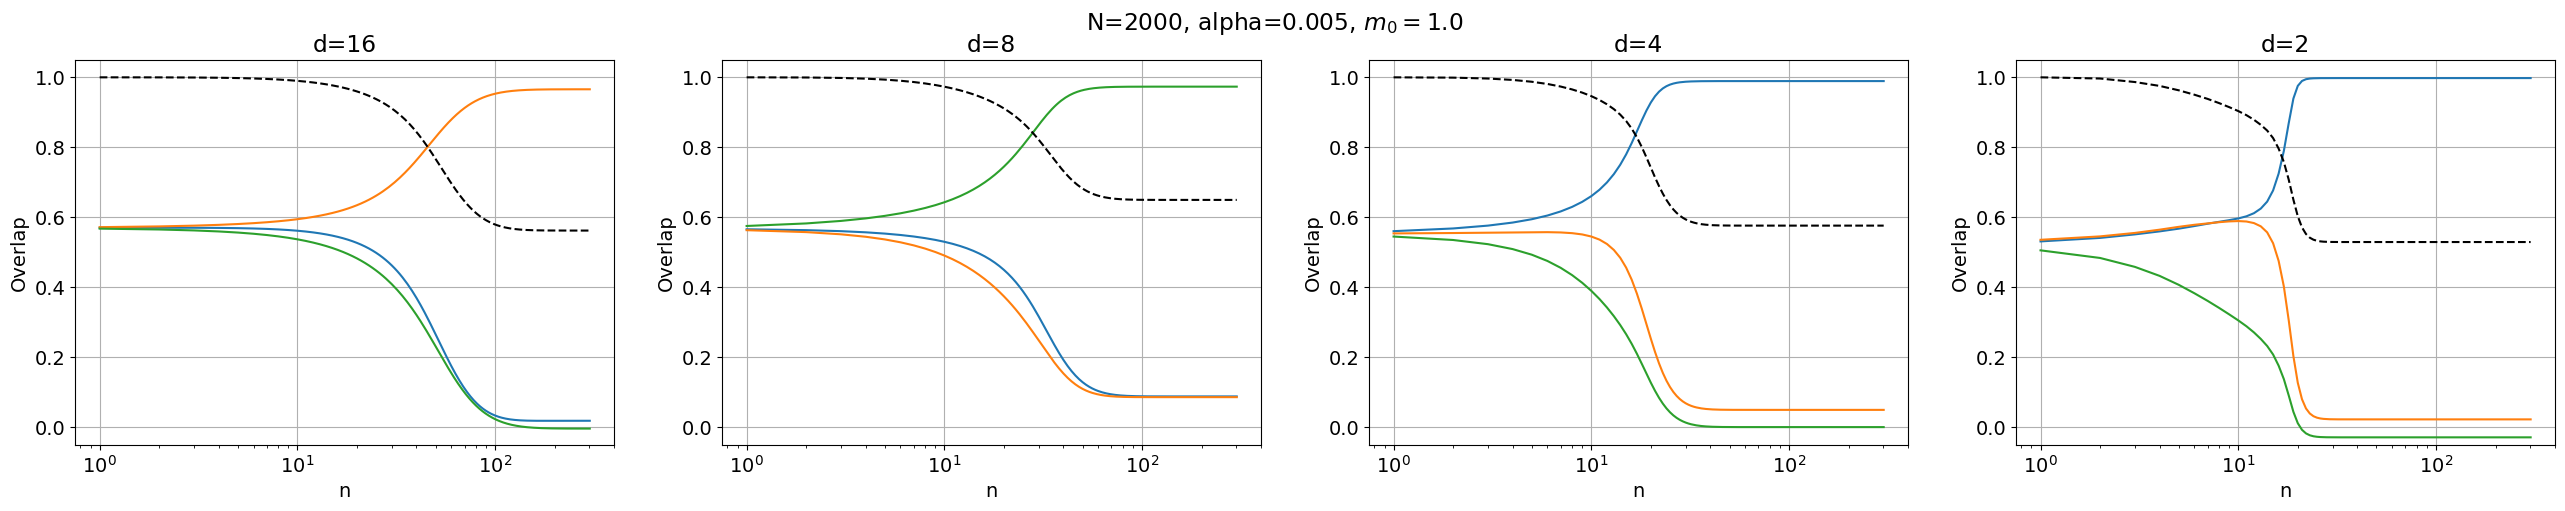

In [ ]:
#N_arr = np.array([2000,1000,500,250])
d_arr = np.array([16,8,4,2])
N = 2000
D=0
n = 300

alpha = 0.005
P = int(alpha*N)
num_of_run = 1
on_sphere=True

mix_order = 3
coeff_list = torch.tensor([1., 1., 1.]).to(device)

q0 = 1.

overlap_arr = np.zeros((len(d_arr),num_of_run,n+1,mix_order+1))

fig, axs = plt.subplots(1, len(d_arr), figsize=(8*len(d_arr), 5))
fig.suptitle(r"N={}, alpha={}, $m_0={:.1f}$".format(N,alpha,q0))

for i_d, d in enumerate(d_arr):
    print("P: {}, N: {}, d: {}".format(P,N,d))

    torch.cuda.empty_cache()
    gc.collect()

    dataset = CustomDataset(P, N, D, d, seed=555, sigma=0.5, on_sphere=on_sphere, coefficients="gaussian")
    model = TwoBodiesModel(N, d, on_sphere)

    xi = dataset.xi

    xi_list = create_xi_list(xi, num_of_run, mix_order).to(device)

    model.to(device)
    model.Hebb(xi, 'Tensorial')

    overlap_arr[i_d] = model.run_dynamics_mixture(xi_list, q0, n, coeff_list)

    for element in range(mix_order):
        axs[i_d].plot(np.arange(1,n+2, 1), overlap_arr[i_d,:,:,element].mean(axis=0),'-', label="d={}".format(d))

    axs[i_d].plot(np.arange(1,n+2, 1), overlap_arr[i_d,:,:,-1].mean(axis=0),'--', color="black", label="mixture".format(d))

    axs[i_d].set_ylim((-0.05,1.05))
    axs[i_d].grid()
    axs[i_d].set_xlabel("n")
    axs[i_d].set_ylabel("Overlap")
    axs[i_d].set_xscale("log")

    axs[i_d].set_title(r"d={}".format(d))

P: 10, N: 2000, d: 16
P: 10, N: 2000, d: 8
P: 10, N: 2000, d: 4
P: 10, N: 2000, d: 2


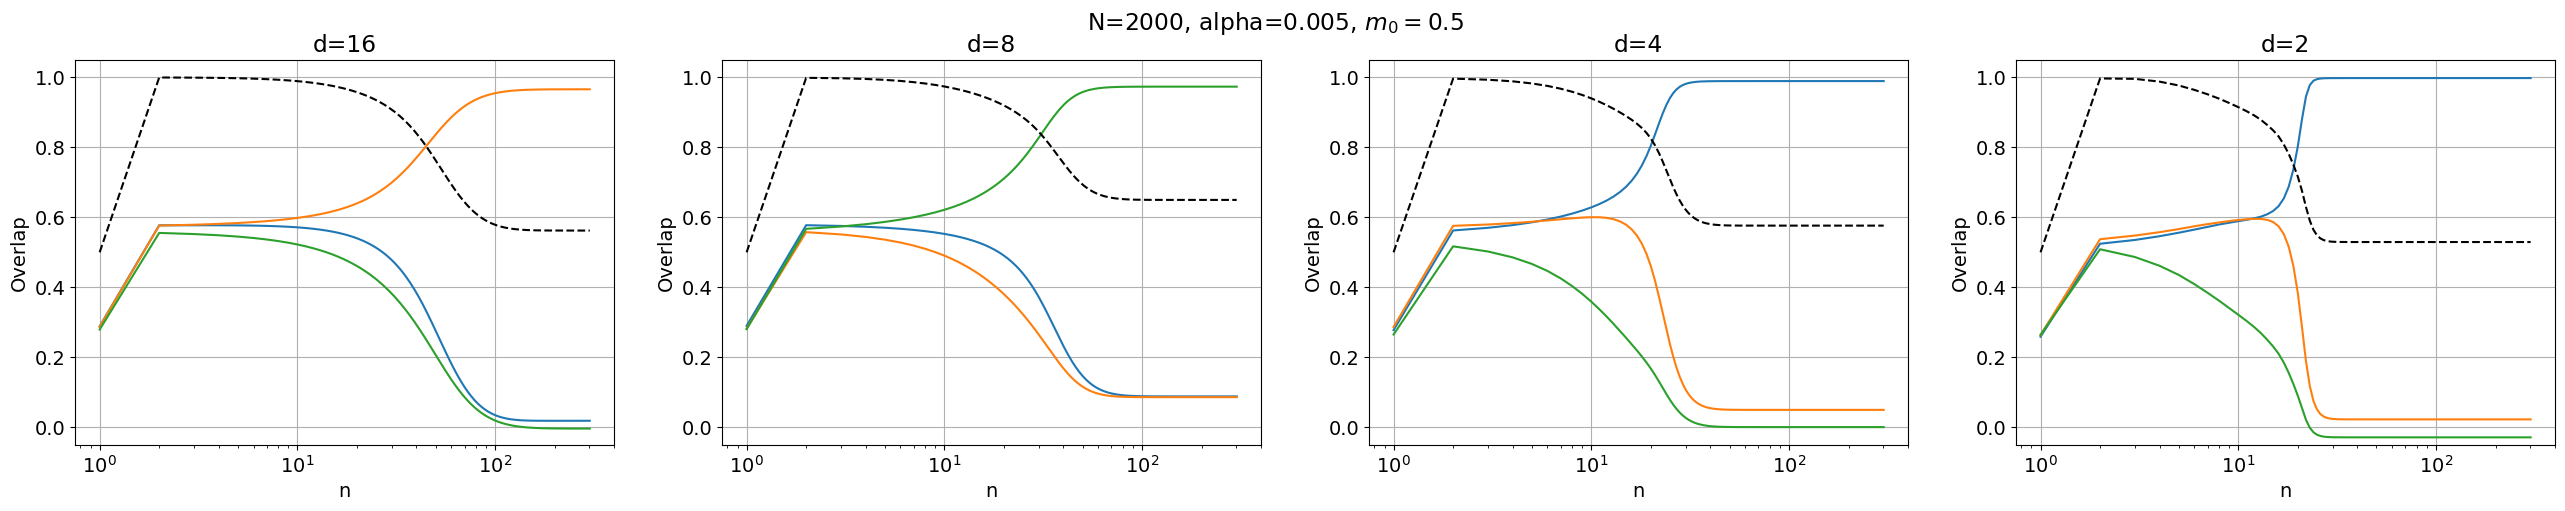

In [ ]:
#N_arr = np.array([2000,1000,500,250])
d_arr = np.array([16,8,4,2])
N = 2000
D=0
n = 300

alpha = 0.005
P = int(alpha*N)
num_of_run = 1
on_sphere=True

mix_order = 3
coeff_list = torch.tensor([1., 1., 1.]).to(device)

q0 = 0.5

overlap_arr = np.zeros((len(d_arr),num_of_run,n+1,mix_order+1))

fig, axs = plt.subplots(1, len(d_arr), figsize=(8*len(d_arr), 5))
fig.suptitle(r"N={}, alpha={}, $m_0={:.1f}$".format(N,alpha,q0))

for i_d, d in enumerate(d_arr):
    print("P: {}, N: {}, d: {}".format(P,N,d))

    torch.cuda.empty_cache()
    gc.collect()

    dataset = CustomDataset(P, N, D, d, seed=555, sigma=0.5, on_sphere=on_sphere, coefficients="gaussian")
    model = TwoBodiesModel(N, d, on_sphere)

    xi = dataset.xi

    xi_list = create_xi_list(xi, num_of_run, mix_order).to(device)

    model.to(device)
    model.Hebb(xi, 'Tensorial')

    overlap_arr[i_d] = model.run_dynamics_mixture(xi_list, q0, n, coeff_list)

    for element in range(mix_order):
        axs[i_d].plot(np.arange(1,n+2, 1), overlap_arr[i_d,:,:,element].mean(axis=0),'-', label="d={}".format(d))

    axs[i_d].plot(np.arange(1,n+2, 1), overlap_arr[i_d,:,:,-1].mean(axis=0),'--', color="black", label="mixture".format(d))

    axs[i_d].set_ylim((-0.05,1.05))
    axs[i_d].grid()
    axs[i_d].set_xlabel("n")
    axs[i_d].set_ylabel("Overlap")
    axs[i_d].set_xscale("log")

    axs[i_d].set_title(r"d={}".format(d))

P: 10, N: 2000, d: 16


<ipython-input-59-254e01b4d587>:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  overlap_arr[i_d] = model.run_dynamics_mixture(xi_list, q0, n, coeff_list)


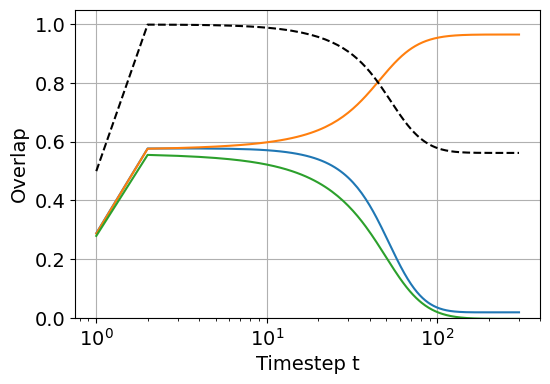

In [ ]:
#N_arr = np.array([2000,1000,500,250])
d_arr = np.array([16])
N = 2000
D=0
n = 300

alpha = 0.005
P = int(alpha*N)
num_of_run = 1
on_sphere=True

mix_order = 3
coeff_list = torch.tensor([1., 1., 1.]).to(device)

q0 = 0.5

overlap_arr = np.zeros((len(d_arr),num_of_run,n+1,mix_order+1))

plt.figure(figsize=(6,4))

for i_d, d in enumerate(d_arr):
    print("P: {}, N: {}, d: {}".format(P,N,d))

    torch.cuda.empty_cache()
    gc.collect()

    dataset = CustomDataset(P, N, D, d, seed=555, sigma=0.5, on_sphere=on_sphere, coefficients="gaussian")
    model = TwoBodiesModel(N, d, on_sphere)

    xi = dataset.xi

    xi_list = create_xi_list(xi, num_of_run, mix_order).to(device)

    model.to(device)
    model.Hebb(xi, 'Tensorial')

    overlap_arr[i_d] = model.run_dynamics_mixture(xi_list, q0, n, coeff_list)

    for element in range(mix_order):
        plt.plot(np.arange(1,n+2, 1), overlap_arr[i_d,:,:,element].mean(axis=0),'-', label="d={}".format(d))

    plt.plot(np.arange(1,n+2, 1), overlap_arr[i_d,:,:,-1].mean(axis=0),'--', color="black", label="mixture".format(d))

    plt.ylim((0.,1.05))
    plt.grid()
    plt.xlabel("Timestep t")
    plt.ylabel("Overlap")
    plt.xscale("log")



## At first step

4it [00:28,  7.02s/it]


Text(0.5, 1.0, 'N=500, P=250')

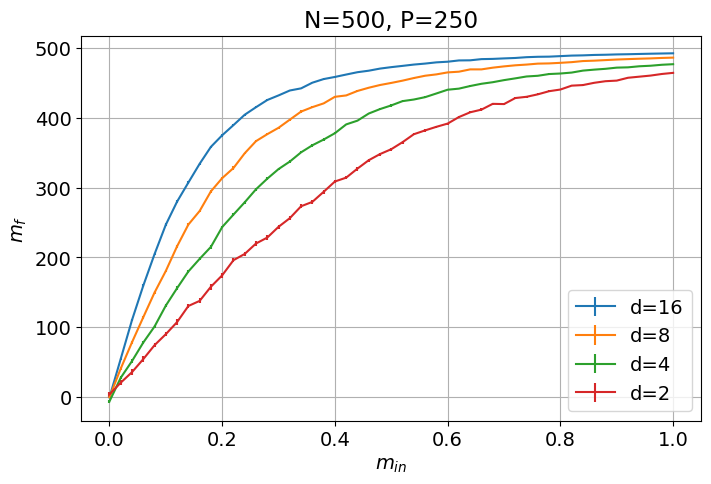

In [13]:
N=500
D=0

num_of_run = 20

d_arr = np.array([16,8,4,2])

n=1

on_sphere = True

plt.figure(figsize=(8,5))

init_overlaps_array = np.arange(0,1.01,0.02)

basins = np.zeros((len(d_arr), len(init_overlaps_array), num_of_run))

for i_d, d in tqdm(enumerate(d_arr)):
    P = 250
    dataset = CustomDataset(P, N, D, d, seed=555, sigma=0.5, on_sphere=on_sphere, coefficients="gaussian")
    model = TwoBodiesModel(N, d, on_sphere)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
    xi = dataset.xi

    model.to(device)

    model.Hebb(xi, 'Tensorial')

    overlaps_final = basins_of_attraction_inp_vectors(dataset.xi[:num_of_run].to(device), init_overlaps_array, model, n)

    basins[i_d] = overlaps_final

    #overlaps_final2 = basins_of_attraction_inp_vectors(dataset.xi[:num_of_run].to(device), init_overlaps_array, model2, n)
    #overlaps_final3 = basins_of_attraction_inp_vectors(dataset.xi[:num_of_run].to(device), init_overlaps_array, model_symm, n)

    plt.errorbar(init_overlaps_array, np.mean(overlaps_final, axis=1), yerr=np.std(overlaps_final, axis=1)/(np.sqrt(num_of_run)), fmt='-', label=r"d={}".format(d))
    #plt.errorbar(init_overlaps_array, np.mean(overlaps_final2, axis=1), yerr=np.std(overlaps_final2, axis=1)/np.sqrt(num_of_run), fmt='-', label="Hebb")
    #plt.errorbar(init_overlaps_array, np.mean(overlaps_final3, axis=1), yerr=np.std(overlaps_final3, axis=1)/np.sqrt(num_of_run), fmt='-', label="Symmetrized a{}".format(alpha))

plt.legend()
#plt.ylim(0,1.05)
plt.xlabel(r"$m_{in}$")
plt.ylabel(r"$m_f$")
plt.grid()
plt.title(r"N={}, P={}".format(N,P))

In [15]:
name_save = "retrieval_maps_N500_P250"
np.save(data_PATH+name_save, basins)

# Dynamics



In [ ]:
#N_arr = np.array([2000,1000,500,250])
d_arr = np.array([32,16,8,4,2])
N = 500
D=0
n = 10
b = 10

alpha = 0.5

overlap_arr = np.zeros((len(d_arr),b,1+n))

q0 = 0.5

for i_d, d in enumerate(d_arr):
    P = int(alpha*N)  # alpha1

    on_sphere=True
    print("P: {}, N: {}, d: {}".format(P,N,d))

    torch.cuda.empty_cache()
    gc.collect()

    dataset = CustomDataset(P, N, D, d, seed=555, sigma=0.5, on_sphere=on_sphere, coefficients="gaussian")
    model = TwoBodiesModel(N, d, on_sphere)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
    xi = dataset.xi

    model.to(device)

    model.Hebb(xi, 'Tensorial')

    init_data = xi[:b].to(device)
    input_vectors = gen_rotated_conf(init_data, q0)
    input_vectors = model.normalize_x(input_vectors)

    overlap_max_n_xi, overlap_max_n_f, max_overlap_xi, max_overlap_f, final_overlap,_, overlap_argmax = converge(input_vectors, model, dataset, n)

    dot_product_mean = torch.einsum("bia,bia->b",input_vectors.cpu(), xi[:b]).detach().numpy()/N
    dot_product_mean = np.reshape(dot_product_mean, (b,1))
    overlap = np.concatenate((dot_product_mean,overlap_max_n_xi), axis=1)
    overlap_arr[i_d] = overlap

P: 250, N: 500, d: 32
P: 250, N: 500, d: 16
P: 250, N: 500, d: 8
P: 250, N: 500, d: 4
P: 250, N: 500, d: 2


## Graph dynamics vs timesteps


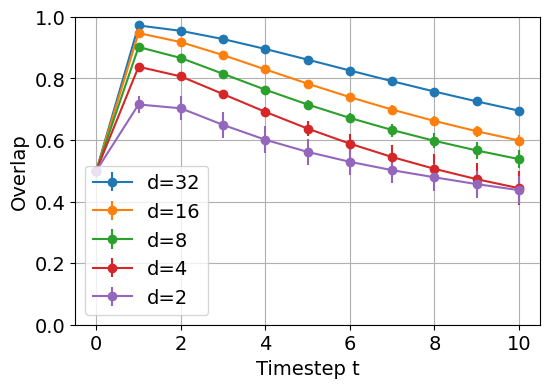

In [ ]:
plt.figure(figsize=(6,4))

for i_d, d in enumerate(d_arr):
    plt.errorbar(np.arange(0,n+1, 1), overlap_arr[i_d].mean(axis=0), overlap_arr[i_d].std(axis=0), fmt='-o', label="d={}".format(d))
plt.xlabel("Timestep t")
plt.ylabel("Overlap")
plt.ylim(0,1)
#plt.title(r"N={}, P=500".format(N))
plt.legend(loc="lower left")
plt.grid()